# CREATE GRAPH AND POLYGON FOLDERS

In [2]:
# general
import os
from tqdm import tqdm
import numpy as np
import pickle

# plot + graph
import matplotlib.pyplot as plt
import networkx as nx

# own
from utils_rplan import ROOM_ARRAY_Z
from plot import plot_graph_rplan, plot_polygons_rplan
from rplan_process.structurize import extract_polygons_from_image, extract_full_graph_from_polygons

# settings
PATH_DATA = 'C:\\Users\\caspervanengel\\OneDrive\\Documents\\PHD\\1_data\\rplan\\0-full'
PATH_COL = os.path.join(PATH_DATA, 'color', 'train')
PATH_ORIG = os.path.join(PATH_DATA, 'original')
PATH_TOPO = os.path.join(PATH_DATA, 'graph')
PATH_GEOM = os.path.join(PATH_DATA, 'geometry')

PATH_IOU = os.path.join(PATH_DATA, 'iou')
PATH_GED_IOU = os.path.join(PATH_DATA, 'ged_iou')     # array indicating iou and ged scores

# colors
COLORS = [np.array(ROOM_ARRAY_Z[n][1])/255 for n in range(18)]

# classes
ROOM_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
DOOR_CLASSES = [17]
WALL_CLASSES = [12, 14, 15, 16, 17]

ModuleNotFoundError: No module named 'rplan_process'

## SAVE GRAPHS AND POLYGONS

In [19]:
for file in tqdm(os.listdir(PATH_ORIG)):
    id = file[:-4]     # remove '.PNG'

    # names to save files
    save_file_geom = os.path.join(PATH_GEOM, f'{id}.pickle')
    save_file_graph = os.path.join(PATH_TOPO, f'{id}.pickle')

    # only continue if non existing file
    if os.path.exists(save_file_geom) and os.path.exists(save_file_graph): continue
    
    # img_path 2 image 2 poly 2 graph
    img = (255*plt.imread(os.path.join(PATH_ORIG, file))).astype(int)[..., 1]
    polygons = extract_polygons_from_image(img, ROOM_CLASSES, DOOR_CLASSES, WALL_CLASSES, min_area=10)
    room_polygons, door_polygons, _ = polygons[0]
    room_types, _, _ = polygons[1]
    try: # not all graphs can be extracted (rooms with 0 degree or ambiguous doors)
        G = extract_full_graph_from_polygons(room_polygons, door_polygons, room_types, COLORS)
    except: continue

    
    # save graph
    with open(save_file_geom, 'wb') as f:
        pickle.dump(polygons, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(save_file_graph, 'wb') as f:
        pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 80788/80788 [55:25<00:00, 24.29it/s]  


## ID AND IOU IMAGE STACKS

In [ ]:
n = len(os.listdir(PATH_IOU))
imgs_stack = np.zeros((n, 256, 256)).astype(np.uint8)
ids_stack = np.zeros((n)).astype(int)

# // STACK IMAGES
for i, f in tqdm(enumerate(os.listdir(PATH_IOU))):
    # identity
    id = f[:-4]
    ids_stack[i] = int(id)

    # load and drop image
    try: 
        imgs_stack[i] = np.load(os.path.join(PATH_IOU, f'{id}.npy'))
    except: 
        print(f"ID={id} cannot be loaded")
        imgs_stack[i] = np.zeros_like(imgs_stack[0,:,:])

    if i == n - 1: break

# # save
# save_file = os.path.join(PATH_DATA, 'image_stack.npy')
# np.save(save_file, imgs_stack)
# save_file = os.path.join(PATH_DATA, 'ids_stack.npy')
# np.save(save_file, ids_stack)

In [45]:
from tqdm import tqdm

ids_stack = np.load(os.path.join(PATH_DATA, 'ids_stack.npy'))
non_ids_stack = []

for f in tqdm(os.listdir(PATH_ORIG)):
	f = int(f[:-4])
	if f not in ids_stack:
		non_ids_stack.append(f)

non_ids_stack = np.array(non_ids_stack)

# save
# np.save(os.path.join(PATH_DATA, 'non_ids_stack.npy'), non_ids_stack)

# print(ids_stack)
# print(non_ids_stack)

# # check for overlap
# print(f"{np.sum((np.array([(v in ids_stack) for v in non_ids_stack])))}")

100%|██████████| 80788/80788 [00:02<00:00, 33558.58it/s]


[  10  100 1000 ... 9995 9997 9999]
[    0     1 10008 ...  9994  9996  9998]
0


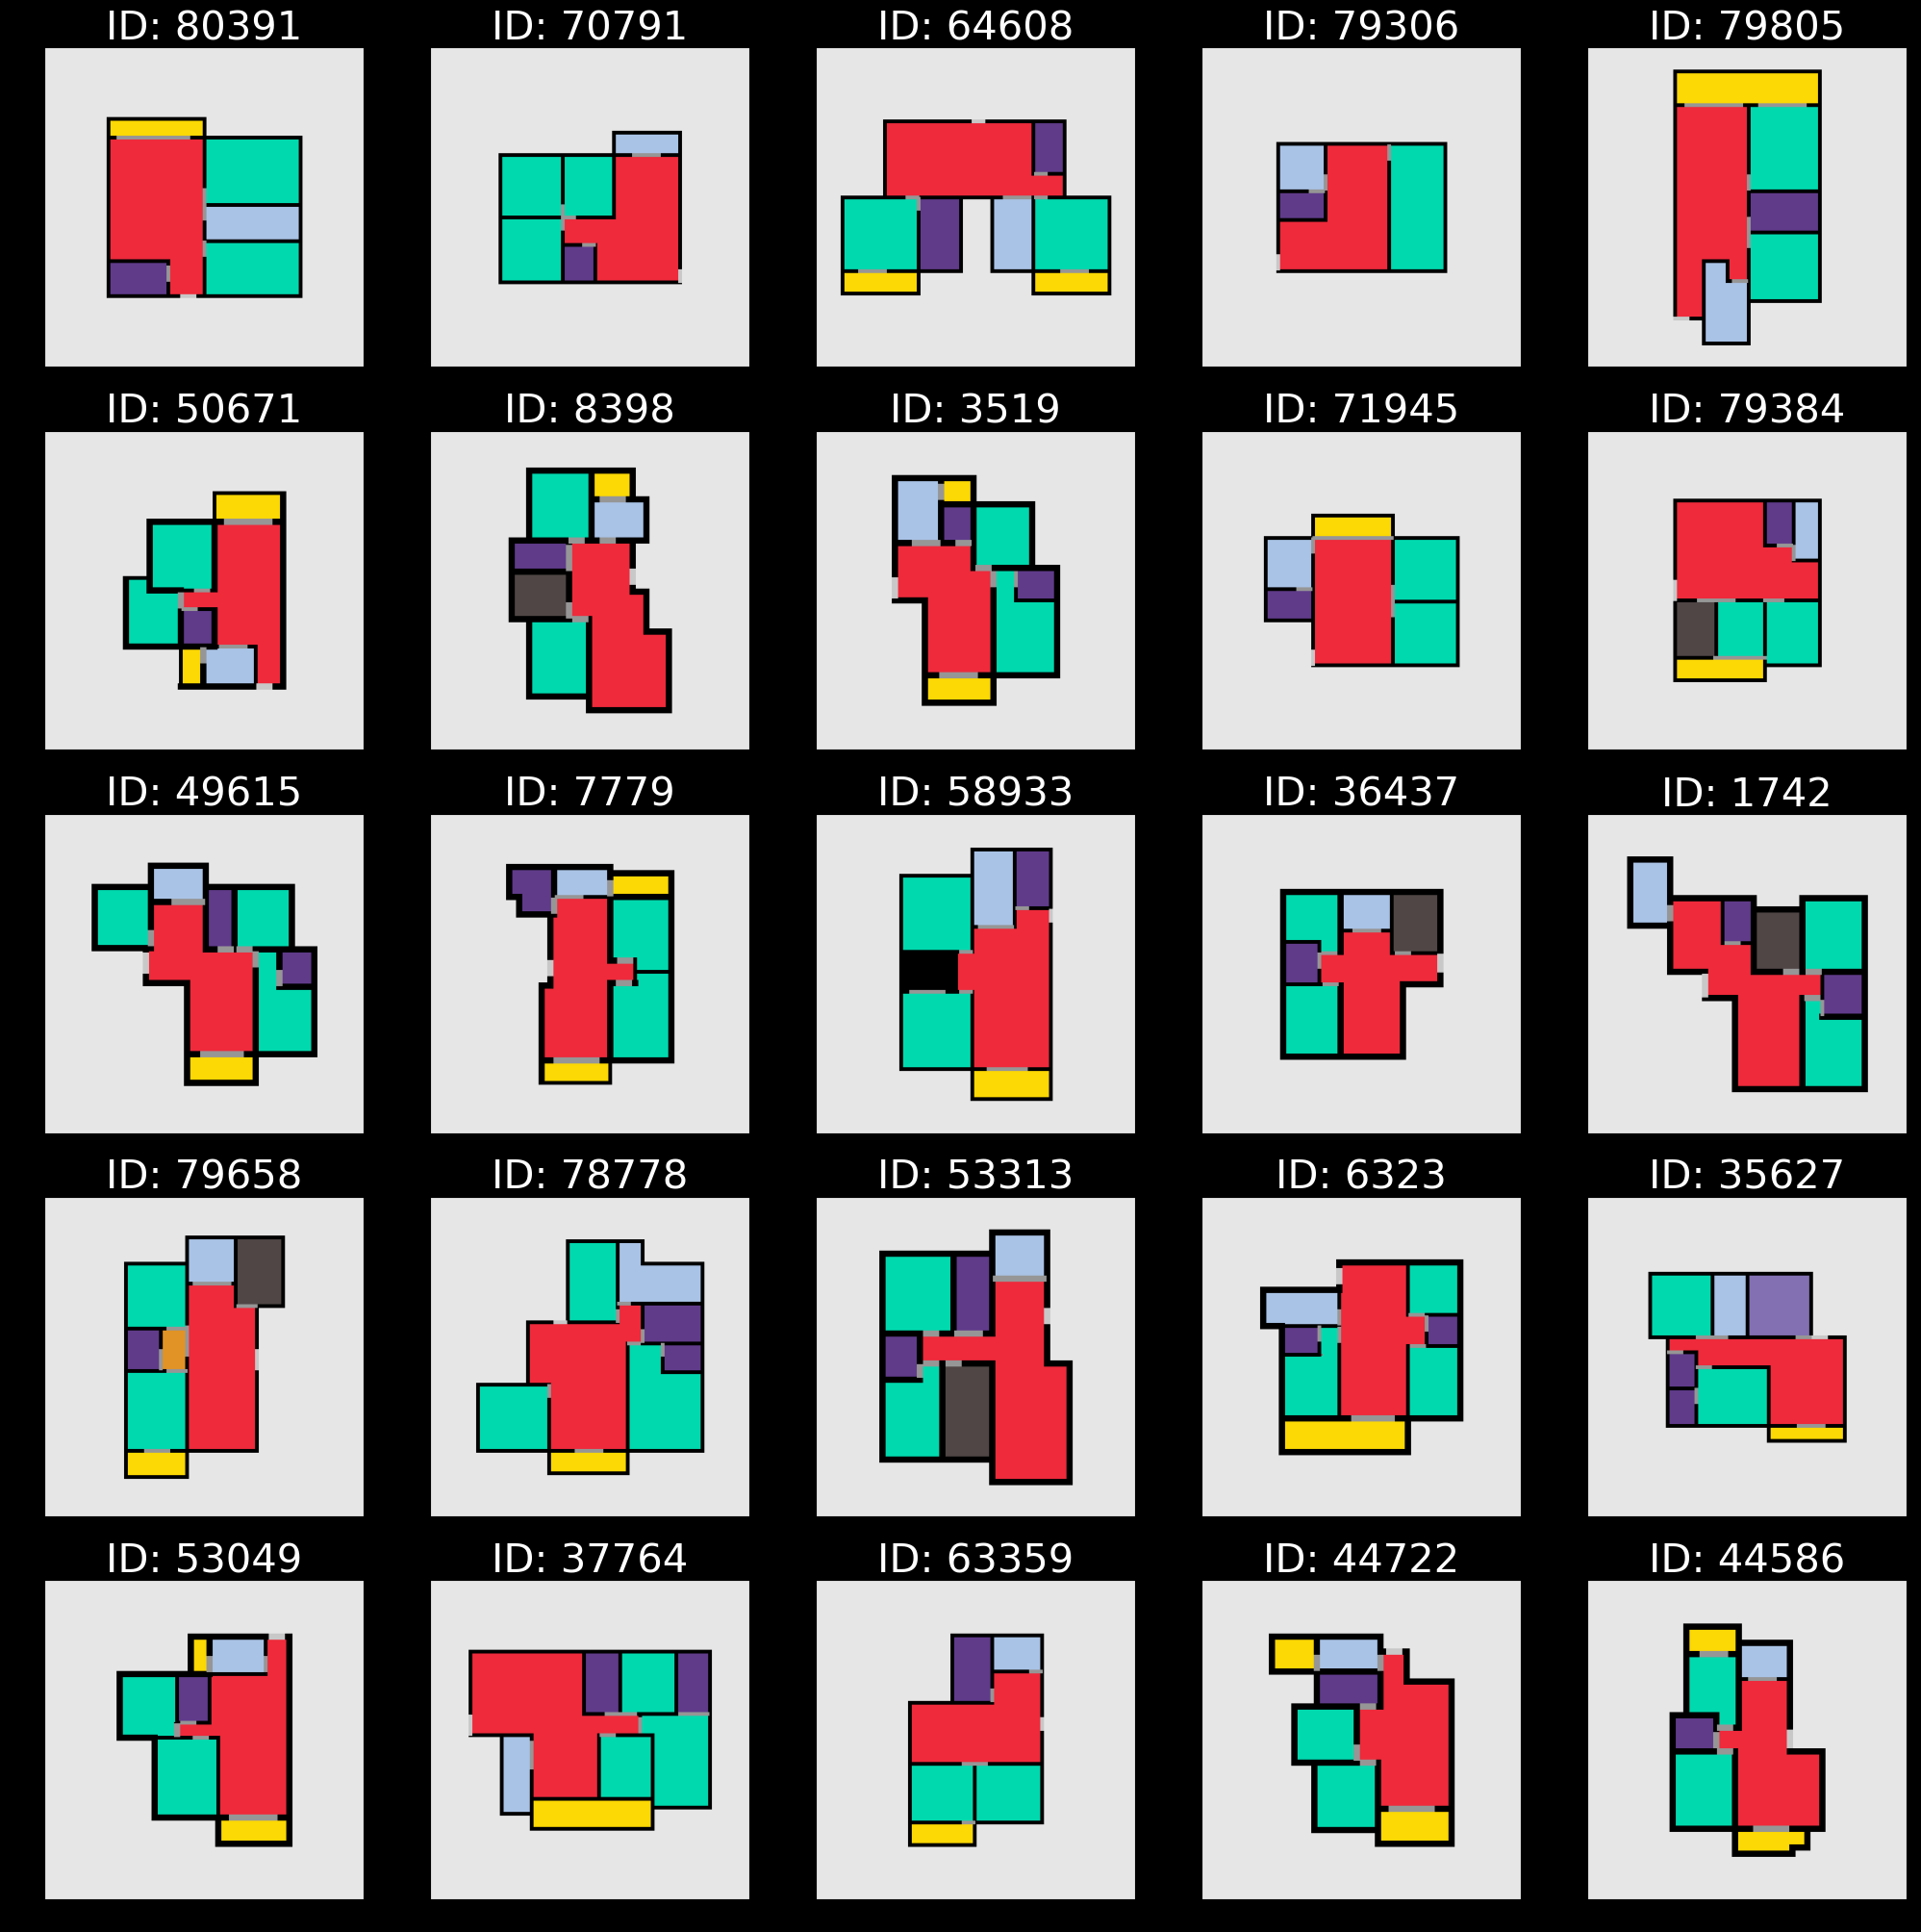

In [49]:
import random
from copy import deepcopy

stop = 25
ncols = int(np.ceil(np.sqrt(stop)))
fs = 5
fig, axs = plt.subplots(ncols, ncols, figsize=(ncols*fs, ncols*fs))
axs = axs.flatten()

# randomly shuffle identities (locally)
non_ids  = np.load(os.path.join(PATH_DATA, 'non_ids_stack.npy'))
random.Random(4).shuffle(non_ids)

i = 0
n = 0
while i < stop:

    id = non_ids[n]
    n += 1

    # img
    try: 
        img_path = os.path.join(PATH_COL, f'{id}.png')
        img = (255*plt.imread(img_path)).astype(int)[..., :3]
    except: 
        continue

    axs[i].imshow(img)
    axs[i].set_title(f"ID: {id}", color='white', fontsize=fs*6)

    i += 1

fig.set_facecolor('black')

## TRAIN / VAL / TEST SPLITS

In [53]:
import random

ids_stack = np.load(os.path.join(PATH_DATA, 'ids_stack.npy'))

# / dataset
n = ids_stack.shape[0] # ~56k

# / train
ratio = 0.8       # ~80% for train (10% for val and test)
nt = int(ratio*n) # ~45k
if (n - nt) % 2 == 1: nt += 1 # add one if odd number

# / val and test
nv = int((n - nt)/2) # ~5k

# / assign ids
# random shuffle (local seed through random.Random(<seed-nr>))
idxs = np.arange(0, n)
random.Random(4).shuffle(idxs) 
train_idx = np.sort(idxs[:nt])
val_idx = np.sort(idxs[nt:nt+nv])
test_idx = np.sort(idxs[nt+nv:])

print(f"Dataset:"
      f"\n\twhole:\t{n}"
      f"\n\ttrain:\t{nt}"
      f"\n\tval:\t{nv}"
      f"\n\ttest:\t{nv}")

# # check for overlap
# print(f"{np.sum((np.array([(v in val_idx) for v in train_idx])))}")
# print(f"{np.sum((np.array([(v in test_idx) for v in train_idx])))}")
# print(f"{np.sum((np.array([(v in val_idx) for v in test_idx])))}")
# print(train_idx[:15])
# print(val_idx[:15])
# print(test_idx[:15])

# # can also use split indices that were already created before !!
# np.save(os.path.join(PATH_DATA, 'train_idx.npy'), train_idx)
# np.save(os.path.join(PATH_DATA, 'val_idx.npy'), val_idx)
# np.save(os.path.join(PATH_DATA, 'test_idx.npy'), test_idx)

Dataset:
	whole:	56565
	train:	45253
	val:	5656
	test:	5656


## CHECKING

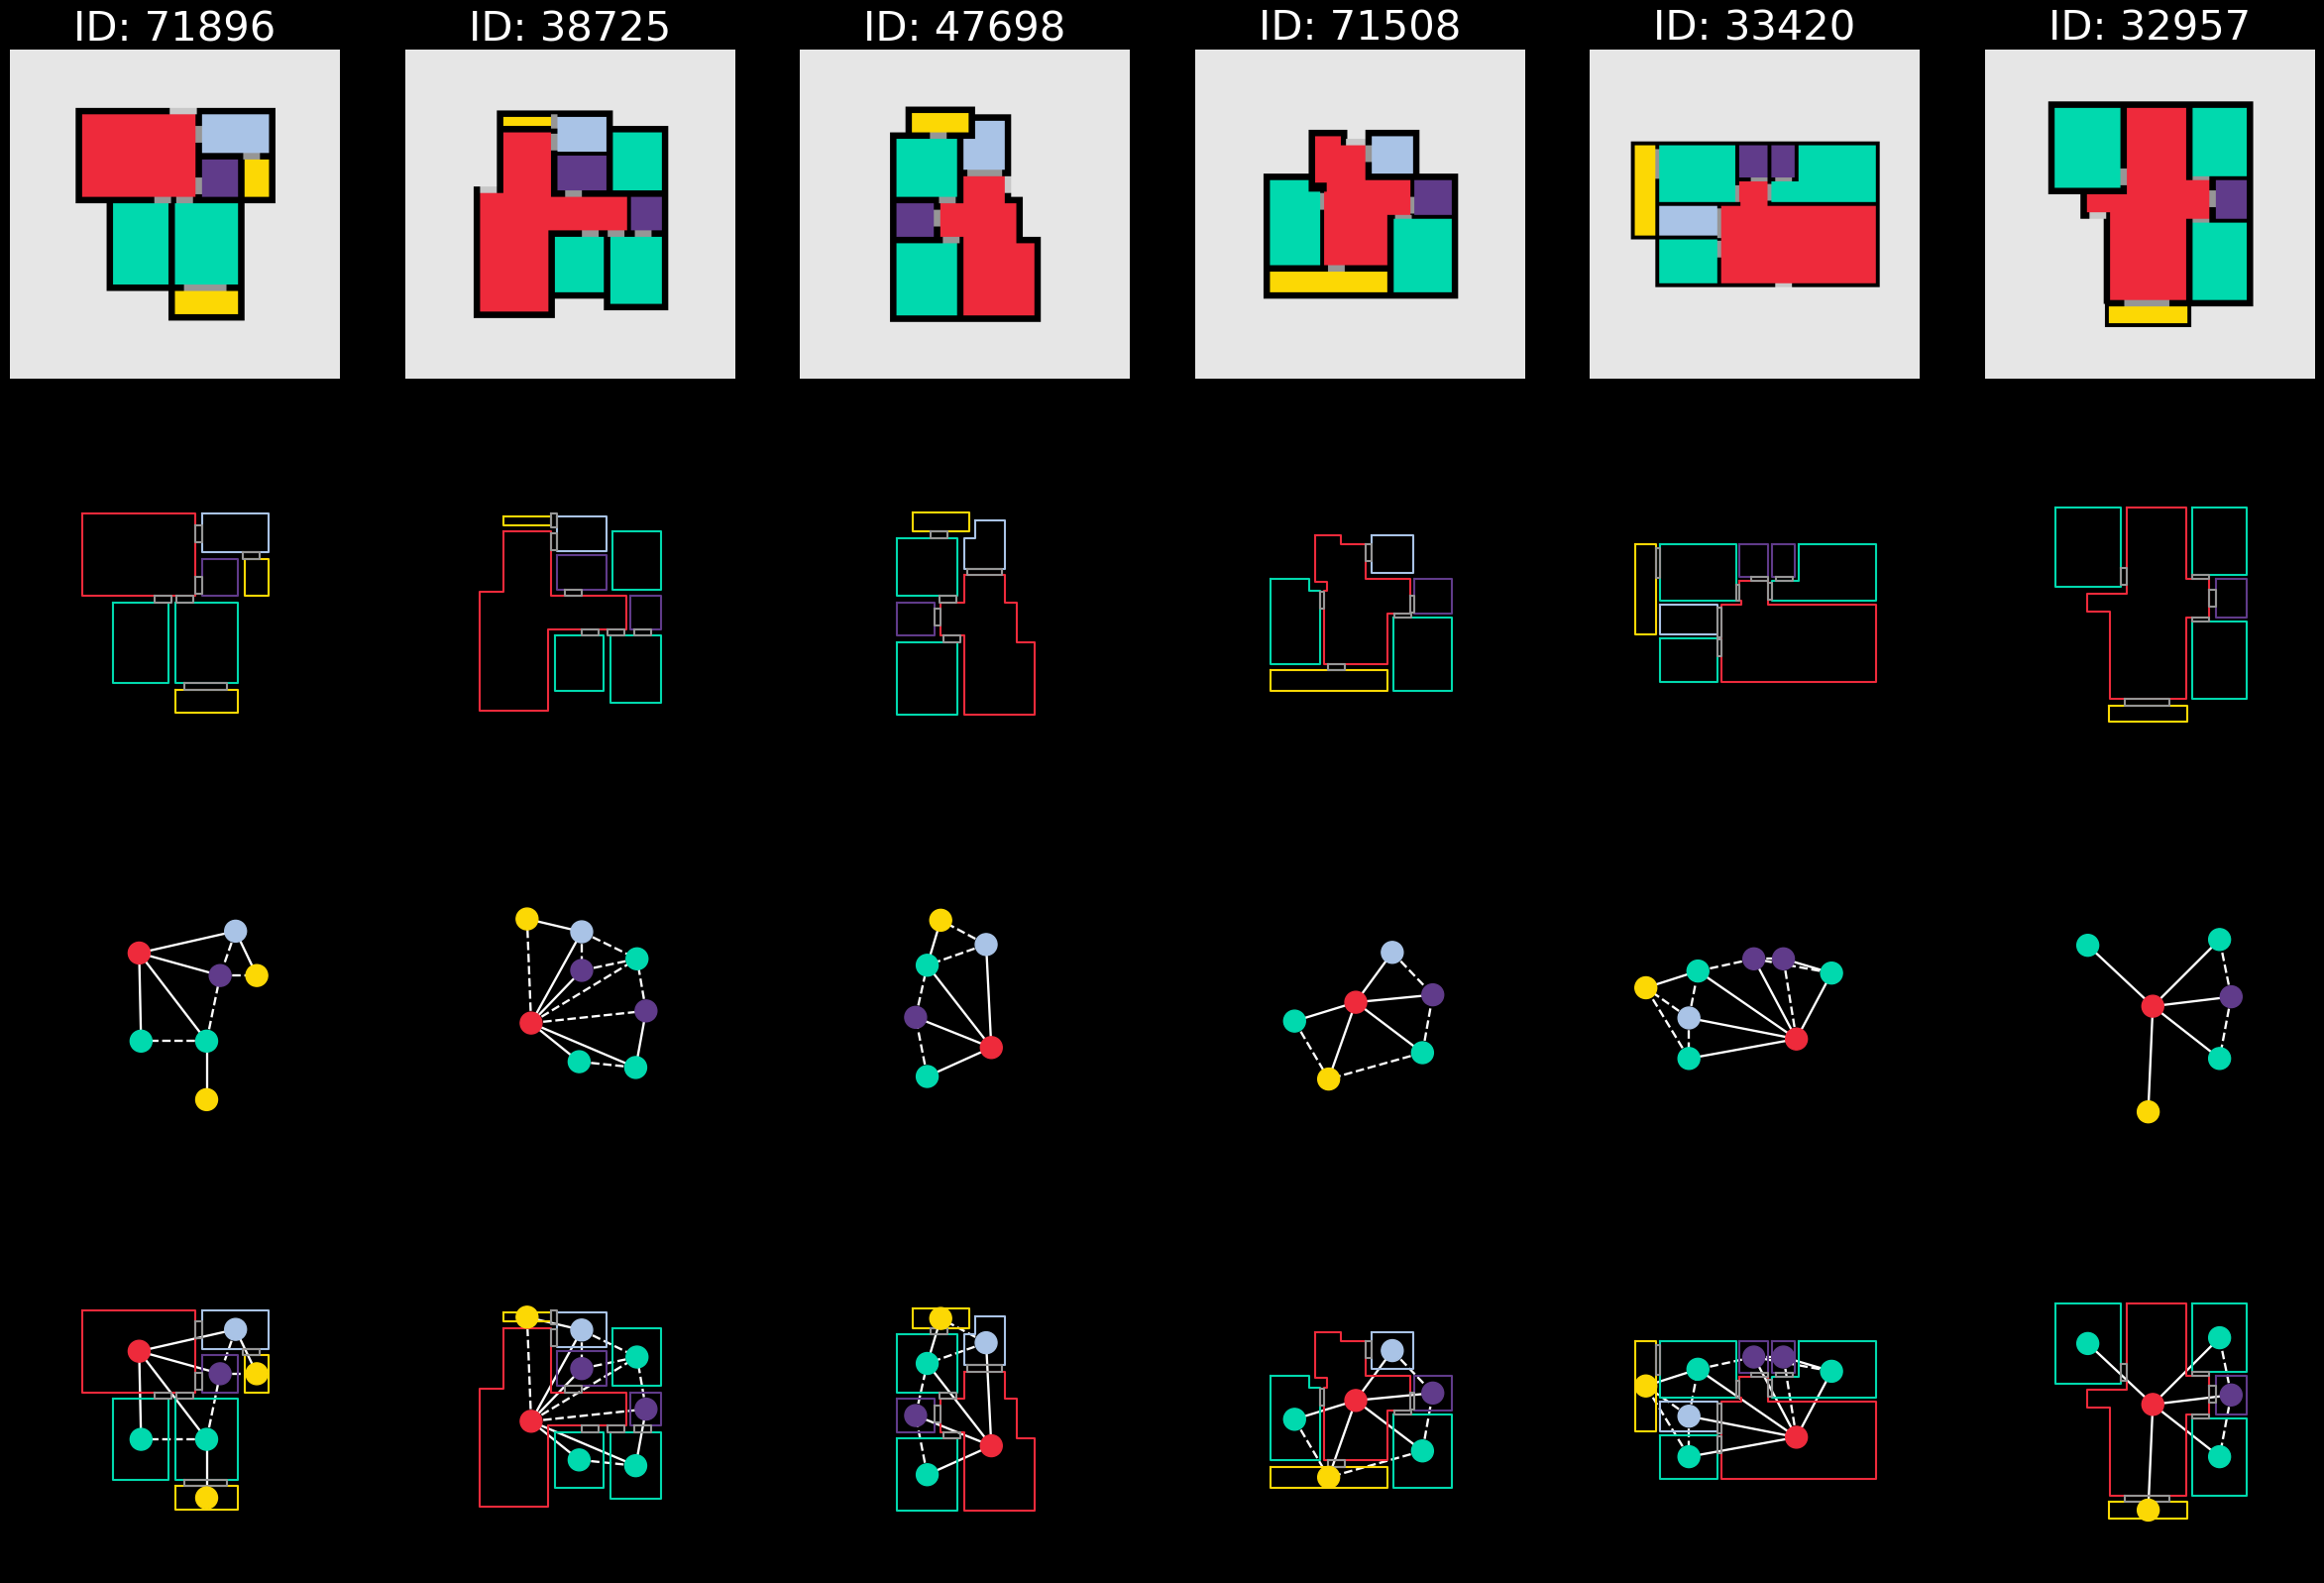

In [17]:
import random
from copy import deepcopy

stop = 6
fs = 5
fig, axs = plt.subplots(4, stop, figsize=(stop*fs, 4*fs))
axs = axs.flatten()

# randomly shuffle identities (locally)
IDS  = np.load(os.path.join(PATH_DATA, 'ids_stack.npy'))
ids = deepcopy(IDS)
random.Random(4).shuffle(ids)

i = 0
n = 0
while i < stop:

    id = ids[n]
    n += 1

    # img
    try: 
        img_path = os.path.join(PATH_COL, f'{id}.png')
        img = (255*plt.imread(img_path)).astype(int)[..., :3]
    except: 
        continue

    save_file_geom = os.path.join(PATH_GEOM, f'{id}.pickle')
    save_file_graph = os.path.join(PATH_TOPO, f'{id}.pickle')

    # unpickle polygon and graph
    with open(save_file_geom, 'rb') as f:
        polygons = pickle.load(f)

    with open(save_file_graph, 'rb') as g:
        graph = pickle.load(g)

    # // PLOTS
    # image
    axs[i].imshow(img)
    axs[i].set_title(f"ID: {id}", color='white', fontsize=fs*6)

    # polygons
    j = i + stop
    plot_polygons_rplan(polygons, axs[j], colors=COLORS)

    # graph
    j += stop
    axs[j].imshow(np.zeros((256, 256)), cmap='gray')
    colors = [graph.nodes[n]['color'] for n in graph.nodes]
    pos = {n: graph.nodes[n]['centroid'] for n in graph.nodes}
    plot_graph_rplan(graph, axs[j], c_node=colors, c_edge='white', dw_edge=True, pos=pos, fs=fs/2)

    # polygons + graphs
    j += stop
    plot_polygons_rplan(polygons, axs[j], colors=COLORS)
    plot_graph_rplan(graph, axs[j], c_node=colors, c_edge='white', dw_edge=True, pos=pos, fs=fs/2)

    for j in (0, stop, stop*2, stop*3):
        axs[i+j].axis('off')
        axs[i+j].set_facecolor('black')
    
    i += 1

fig.set_facecolor('black')